# Outlier detection using rolling statistics

In [1]:
import pandas as pd
import yfinance as yf

In [2]:
df = yf.download("TSLA",
                 start="2019-01-01",
                 end="2020-12-31",
                 progress=False)
df['rtn'] = df['Adj Close'].pct_change()
df = df[['rtn']].copy()

,rtn
Date,
2019-01-02,NaN
2019-01-03,-0.031472
2019-01-04,0.057697
2019-01-07,0.054361
2019-01-08,0.001164
...,...
2020-12-23,0.008808
2020-12-24,0.024443
2020-12-28,0.002901


In [3]:
df_rolling = df[['rtn']].rolling(window=21).agg(['mean', 'std'])
df_rolling.columns = df_rolling.columns.droplevel()

In [4]:
df = df.join(df_rolling)

In [5]:
N_SIGMAS = 3
df['upper'] = df['mean'] + N_SIGMAS * df['std']
df['lower'] = df['mean'] - N_SIGMAS * df['std']

In [6]:
df['outlier'] = (
    (df['rtn'] > df['upper']) | (df['rtn'] < df['lower'])
)

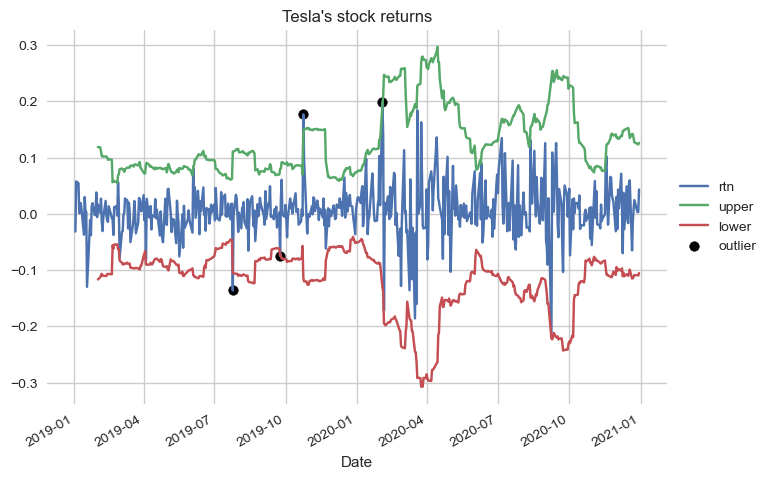

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

fig, ax = plt.subplots()
df[['rtn', 'upper', 'lower']].plot(ax=ax)
ax.scatter(df.loc[df['outlier']].index, 
           df.loc[df['outlier'], 'rtn'],
           color='black', label='outlier')
ax.set_title("Tesla's stock returns")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
def identify_outliers(df, column, window_size, n_sigma):
    """Function for identifying outliers using rolling statistics"""

    df = df[[column]].copy()
    df_rolling = df[[column]].rolling(window=window_size).agg(['mean', 'std'])
    df_rolling.columns = df_rolling.columns.droplevel()

    df = df.join(df_rolling)
    df['upper'] = df['mean'] + n_sigma * df['std']
    df['lower'] = df['mean'] - n_sigma * df['std']

    return ((df[column] > df['upper']) | (df[column] < df['lower']))

# Outlier detection with the Hampel filter

In [10]:
import yfinance as yf
from sktime.transformations.series.outlier_detection import HampelFilter

In [11]:
df = yf.download("TSLA",
                 start="2019-01-01",
                 end="2020-12-31",
                 progress=False)
df['rtn'] = df['Adj Close'].pct_change()

In [12]:
hampel_detector = HampelFilter(window_length=10,
                               return_bool=True)
df['outlier'] = hampel_detector.fit_transform(df['Adj Close'])

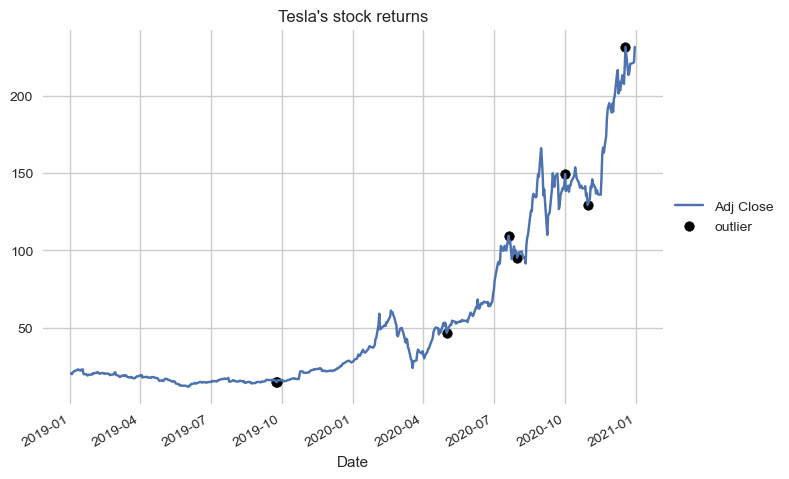

In [13]:
fig, ax = plt.subplots()
df['Adj Close'].plot(ax=ax)
ax.scatter(df.loc[df['outlier']].index,
           df.loc[df['outlier'], 'Adj Close'],
           color='black', label='outlier')
ax.set_title("Tesla's stock returns")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [14]:
df['outlier_rtn'] = hampel_detector.fit_transform(df['rtn'])

/Users/woojin/miniforge3/envs/finance/lib/python3.11/site-packages/sktime/transformations/series/outlier_detection.py:102: UserWarning: Series contains nan values, more nan might be
                added if there are outliers
  Z = self._transform_series(Z)


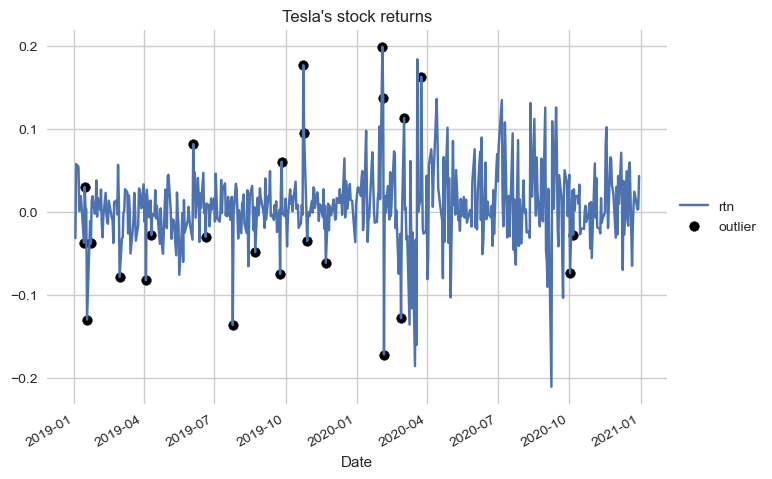

In [15]:
fig, ax = plt.subplots()
df[['rtn']].plot(ax=ax)

ax.scatter(df.loc[df["outlier_rtn"]].index,
           df.loc[df["outlier_rtn"], "rtn"],
           color="black", label="outlier")

ax.set_title("Tesla's stock returns")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [17]:
df.query("outlier == True and outlier_rtn == True")

,Open,High,Low,Close,Adj Close,Volume,rtn,outlier,outlier_rtn
Date,,,,,,,,,
2019-09-24,16.101334,16.132668,14.840667,14.880667,14.880667,193372500,-0.074701,True,True


# Detecting changingpoints in time series

In [19]:
# import yfinance as yf
# from kats.detectors.cusum_detection import CUSUMDetector
# from kats.consts import TimeSeriesData

# Detecting patterns in a time series using the Hurst exponent

In [20]:
import yfinance as yf
import numpy as np
import pandas as pd

<Axes: title={'center': 'S&P 500 (years 2000-2019)'}, xlabel='Date'>

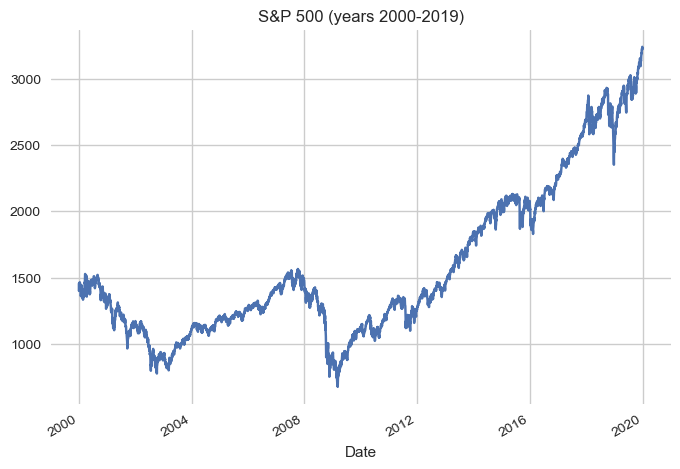

In [21]:
df = yf.download("^GSPC",
                 start="2000-01-01",
                 end="2019-12-31",
                 progress=False)
df["Adj Close"].plot(title="S&P 500 (years 2000-2019)")

In [24]:
def get_hurst_exponent(ts, max_lag=20):
    """Returns the Hurst Exponent of the time series"""

    lags = range(2, max_lag)
    tau = [np.std(np.subtract(ts[lag:], ts[:-lag])) for lag in lags]
    hurst_exp = np.polyfit(np.log(lags), np.log(tau), 1)[0]
    return hurst_exp

In [25]:
for lag in [20, 100, 250, 500, 1000]:
    hurst_exp = get_hurst_exponent(df["Adj Close"].values, lag)
    print(f"Hurst Exponent with {lag} lags: {hurst_exp:.4f}")

Hurst Exponent with 20 lags: 0.4481
Hurst Exponent with 100 lags: 0.4513
Hurst Exponent with 250 lags: 0.4918
Hurst Exponent with 500 lags: 0.5265
Hurst Exponent with 1000 lags: 0.5178


In [27]:
shorter_series = df.loc["2005":"2007", "Adj Close"].values
for lag in [20, 100, 250, 500]:
    hurst_exp = get_hurst_exponent(shorter_series, lag)
    print(f"Hurst Exponent with {lag} lags: {hurst_exp:.4f}")

Hurst Exponent with 20 lags: 0.3989
Hurst Exponent with 100 lags: 0.3215
Hurst Exponent with 250 lags: 0.2507
Hurst Exponent with 500 lags: 0.1258


<Axes: title={'center': 'S&P 500 (years 2005-2007)'}, xlabel='Date'>

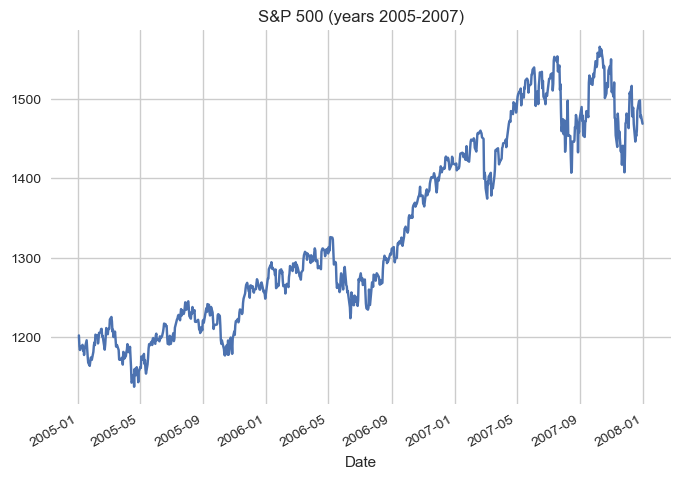

In [30]:
df.loc["2005":"2007", "Adj Close"].plot(title="S&P 500 (years 2005-2007)")

# Investigating stylized facts of asset returns

In [31]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [32]:
df = yf.download("^GSPC",
                 start="2000-01-01",
                 end="2020-12-31",
                 progress=False)
df = df[['Adj Close']].rename(columns={'Adj Close': 'adj_close'})
df['log_rtn'] = np.log(df['adj_close']/df['adj_close'].shift(1))
df = df[['adj_close', 'log_rtn']].dropna()

In [33]:
r_range = np.linspace(min(df['log_rtn']), max(df['log_rtn']), num=1000)
mu = df['log_rtn'].mean()
sigma = df['log_rtn'].std()
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

/var/folders/dt/q9f0jq252ld5kmwg8rqf4pgw0000gn/T/ipykernel_58654/1098158531.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['log_rtn'], kde=False, norm_hist=True, ax=ax[0])


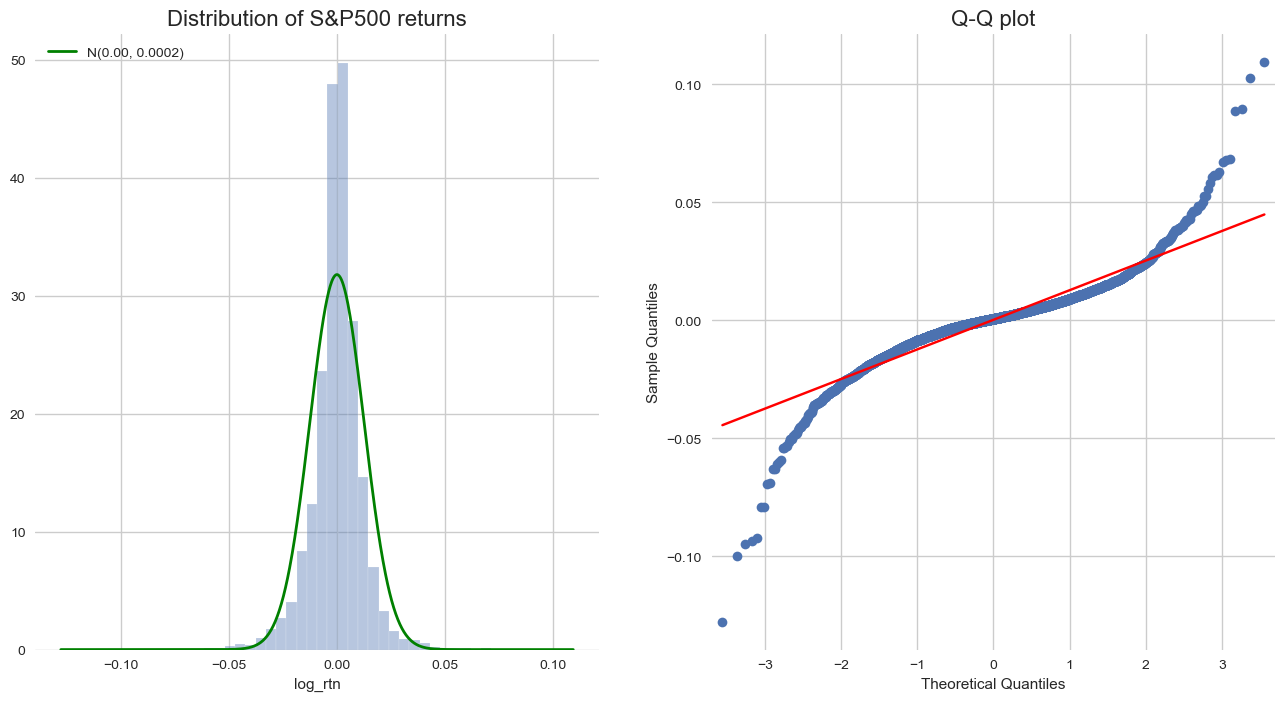

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# histogram
sns.distplot(df['log_rtn'], kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title('Distribution of S&P500 returns', fontsize=16)
ax[0].plot(r_range, norm_pdf, 'g', lw=2, label=f'N({mu:.2f}, {sigma**2:.4f})')
ax[0].legend(loc='upper left');

# Q-Q plot
qq = sm.qqplot(df['log_rtn'].values, line='s', ax=ax[1])
ax[1].set_title('Q-Q plot', fontsize = 16)
plt.show()

In [35]:
jb_test = scs.jarque_bera(df['log_rtn'].values)

print('------------ Descriptive Statistics ------------')
print('Range of dates:', min(df.index.date), '-', max(df.index.date))
print('Number of observations:', df.shape[0])
print(f'Mean: {df["log_rtn"].mean():.4f}')
print(f'Median: {df["log_rtn"].median():.4f}')
print(f'Min: {df["log_rtn"].min():.4f}')
print(f'Max: {df["log_rtn"].max():.4f}')
print(f'Standard Deviation: {df["log_rtn"].std():.4f}')
print(f'Skewness: {df["log_rtn"].skew():.4f}')
print(f'Kurtosis: {df["log_rtn"].kurtosis():.4f}')
print(f'Jarque-Bera statistic: {jb_test[0]:.2f} with p-value: {jb_test[1]:.2f}')

------------ Descriptive Statistics ------------
Range of dates: 2000-01-04 - 2020-12-30
Number of observations: 5282
Mean: 0.0002
Median: 0.0006
Min: -0.1277
Max: 0.1096
Standard Deviation: 0.0126
Skewness: -0.3935
Kurtosis: 10.9538
Jarque-Bera statistic: 26487.80 with p-value: 0.00


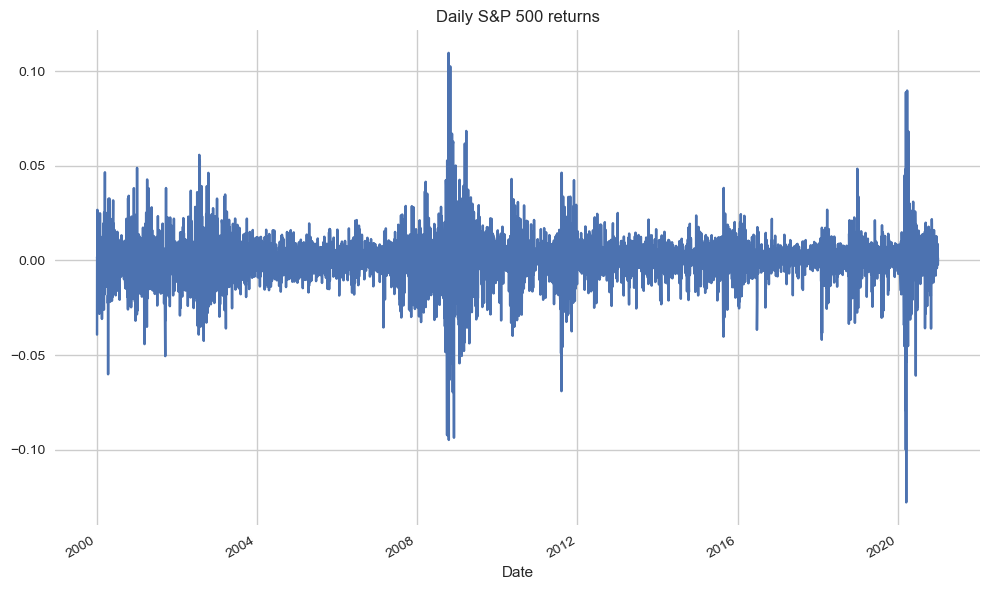

In [36]:
(
    df['log_rtn']
    .plot(title='Daily S&P 500 returns', figsize=(10, 6))
)
sns.despine()
plt.tight_layout()

In [37]:
N_LAGS = 50
SIGNIFICANCE_LEVEL = 0.05

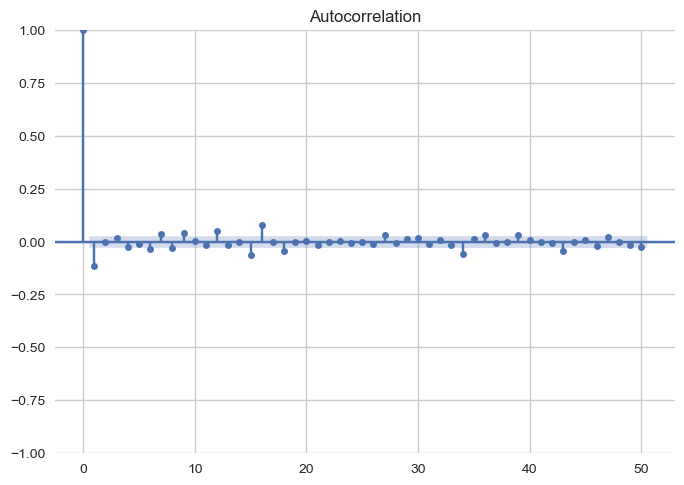

In [38]:
acf = smt.graphics.plot_acf(df['log_rtn'], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plt.show()

## Fact 4. Small and decreasing autocorrelation in squared/absolute returns

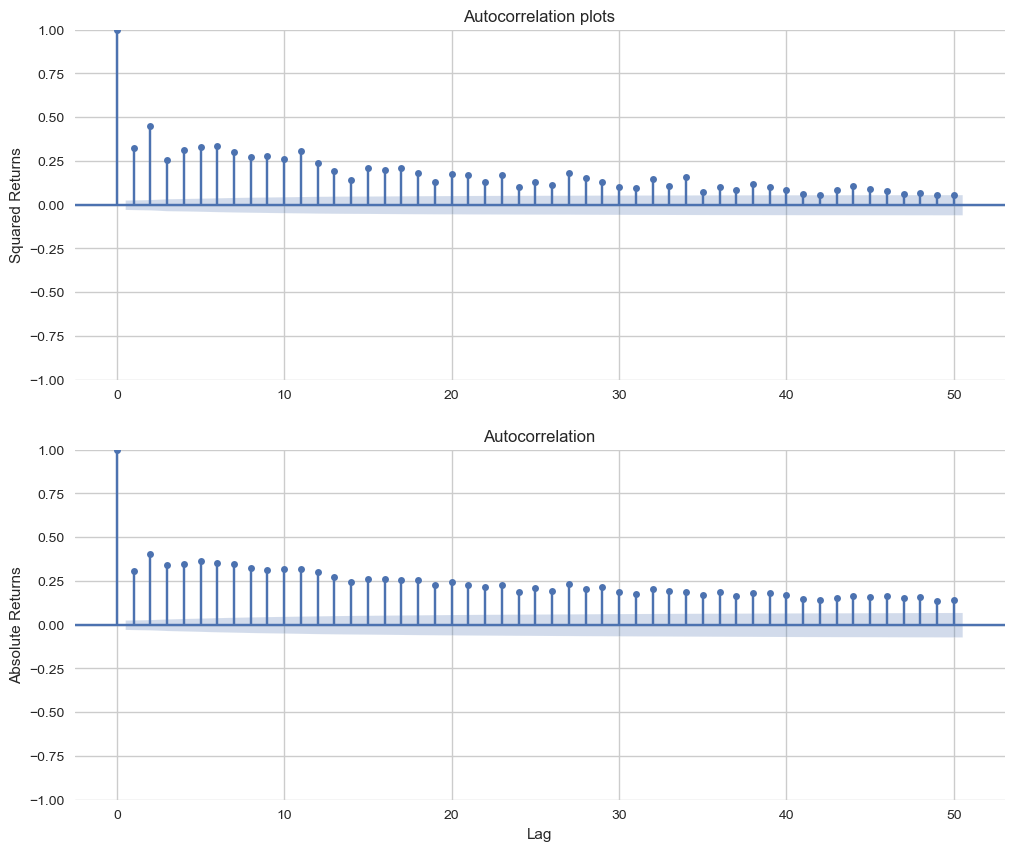

In [39]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
smt.graphics.plot_acf(df['log_rtn']**2, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax[0])
ax[0].set(title='Autocorrelation plots', ylabel='Squared Returns')

smt.graphics.plot_acf(np.abs(df['log_rtn']), lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL, ax=ax[1])
ax[1].set(ylabel='Absolute Returns', xlabel='Lag')
plt.show()

## Pact 5. Leverage effect

In [40]:
df['moving_std_252'] = df[['log_rtn']].rolling(window=252).std()
df['moving_std_21'] = df[['log_rtn']].rolling(window=21).std()

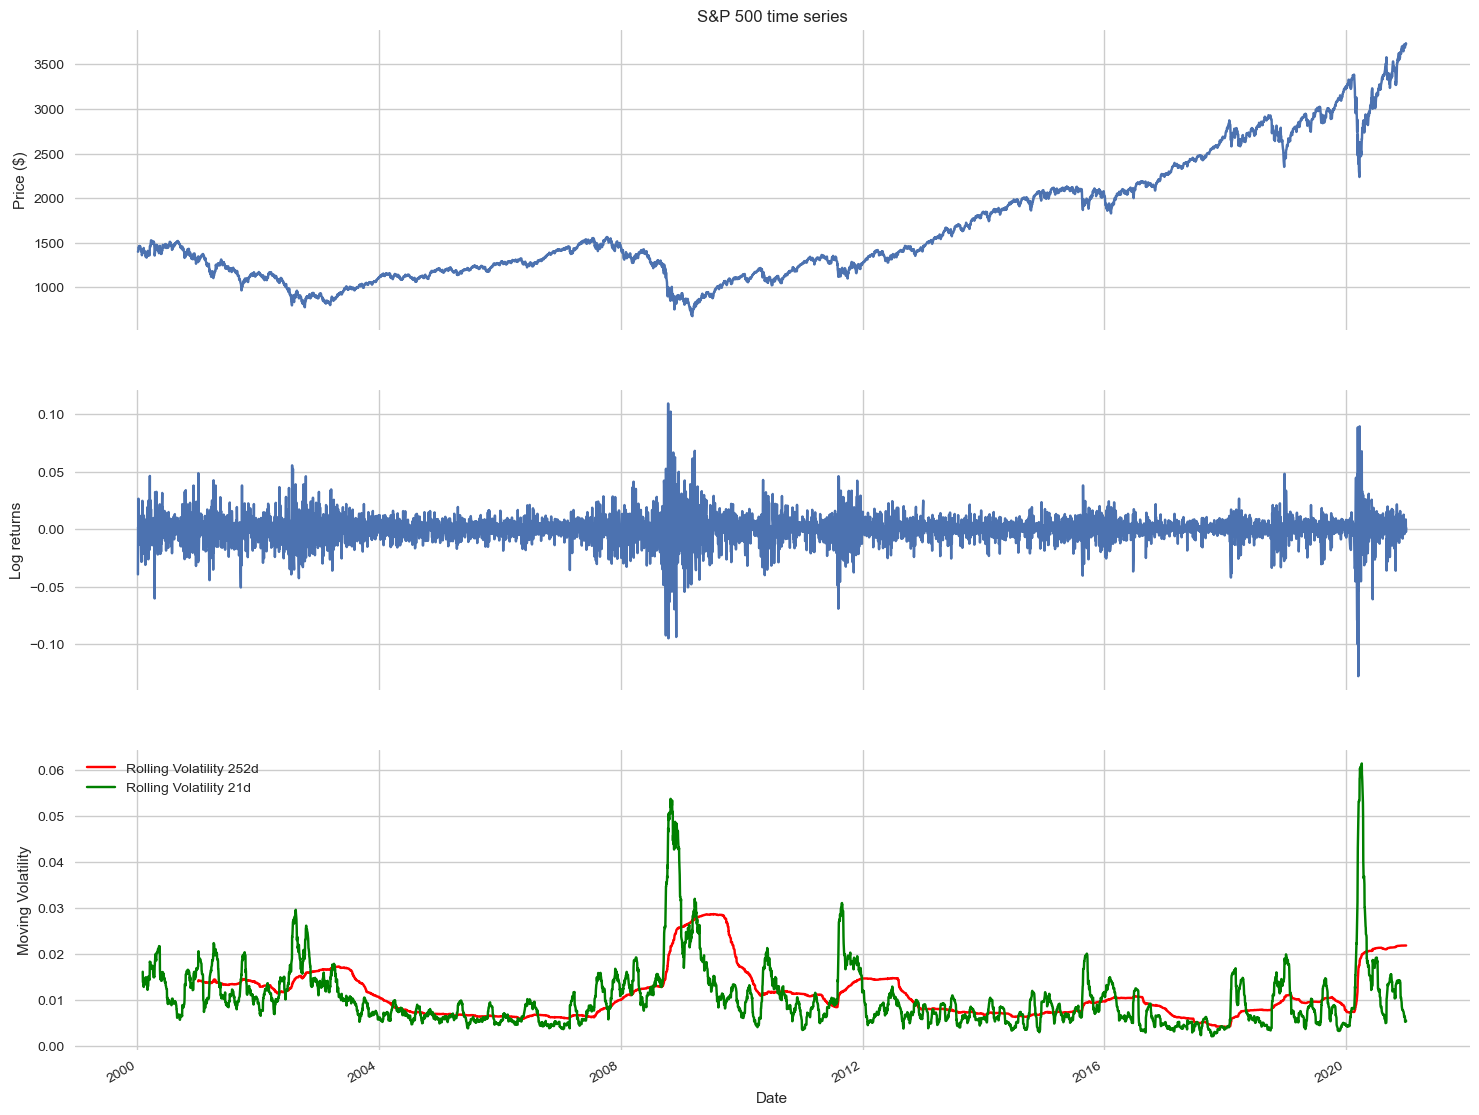

In [42]:
fig, ax = plt.subplots(3, 1, figsize=(18, 15), sharex=True)
df['adj_close'].plot(ax=ax[0])
ax[0].set(title='S&P 500 time series', ylabel='Price ($)')

df['log_rtn'].plot(ax=ax[1])
ax[1].set(ylabel='Log returns')
df['moving_std_252'].plot(ax=ax[2], color='r', label='Rolling Volatility 252d')
df['moving_std_21'].plot(ax=ax[2], color='g', label='Rolling Volatility 21d')
ax[2].set(ylabel='Moving Volatility', xlabel='Date')
ax[2].legend()
plt.show()

In [43]:
df = yf.download(["^GSPC", "^VIX"],
                 start="2000-01-01",
                 end="2020-12-31",
                 progress=False)
df = df[['Adj Close']]
df.columns = df.columns.droplevel(0)
df = df.rename(columns={'^GSPC': 'sp500', '^VIX': 'vix'})

In [44]:
df['log_rtn'] = np.log(df['sp500']/df['sp500'].shift(1))
df['vol_rtn'] = np.log(df['vix']/df['vix'].shift(1))
df.dropna(how='any', inplace=True, axis=0)

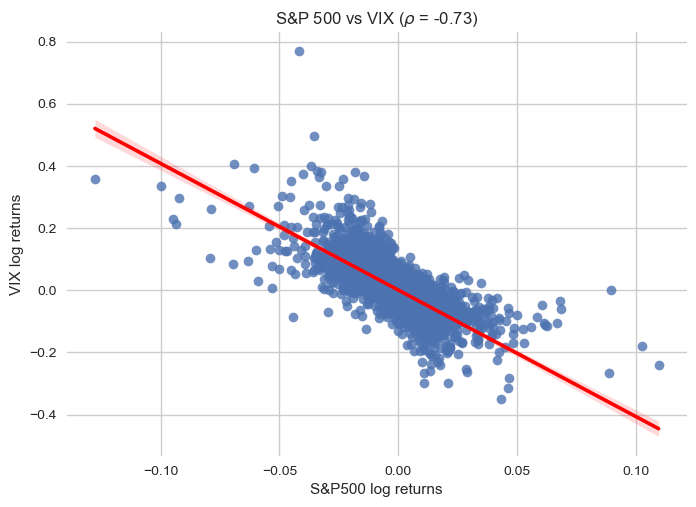

In [45]:
corr_coeff = df.log_rtn.corr(df.vol_rtn)
ax = sns.regplot(x='log_rtn', y='vol_rtn', data=df,line_kws={'color': 'red'})
ax.set(title=f'S&P 500 vs VIX ($\\rho$ = {corr_coeff:.2f})', ylabel='VIX log returns', xlabel='S&P500 log returns')
plt.show()